In [1]:
%load_ext autoreload  
%autoreload 2  
import os
# BLAS uyarısını susturmak ve Numba'yı aktif etmek için:
os.environ["PYTENSOR_FLAGS"] = "mode=NUMBA"

Data Nesnesi:      minimum_time  minimum_time_error       weights  minimum_type  \
0    2.454532e+06            0.000015  4.444444e+09             0   
1    2.454533e+06            0.000015  4.444444e+09             0   
2    2.454536e+06            0.000015  4.444444e+09             0   
3    2.454537e+06            0.000015  4.444444e+09             0   
4    2.454555e+06            0.000015  4.444444e+09             0   
..            ...                 ...           ...           ...   
905  2.459699e+06            0.000015  4.444444e+09             0   
906  2.459711e+06            0.000015  4.444444e+09             0   
907  2.459712e+06            0.000014  5.102041e+09             0   
908  2.459712e+06            0.000014  5.102041e+09             0   
909  2.459717e+06            0.000012  6.944444e+09             0   

                 labels  
0            Literature  
1            Literature  
2            Literature  
3            Literature  
4            Literature  
.

(<Figure size 1000x700 with 2 Axes>,
 (<Axes: ylabel='O−C'>, <Axes: xlabel='Cycle', ylabel='Resid'>))

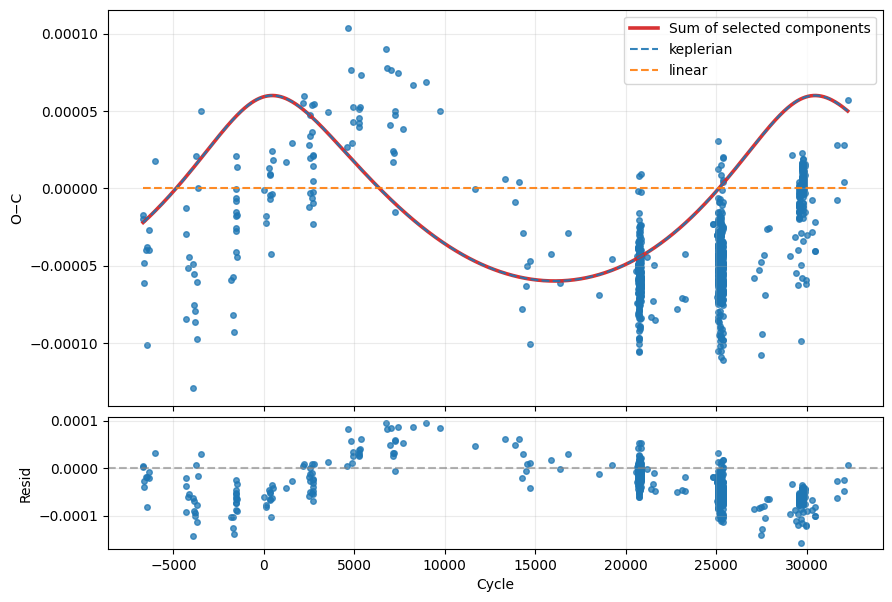

In [2]:
from ocpy.data import Data
from ocpy.oc import Keplerian, Linear, Parameter
from ocpy.oc_pymc import OCPyMC

excel_path = "DD_CrB_Minima_.xlsx"

from ocpy.data import Data

import pandas as pd
from ocpy.oc import OC  # oc.py dosyasının proje yapınıza göre doğru import edildiğinden emin olun

from ocpy.data import Data

file_path = "dd_crb.csv"

column_mapping = {
    "Mintimes": "minimum_time",    
    "Errors": "minimum_time_error",
    "Mintypes": "minimum_type",     
    "Data_group": "labels"          
}

data = Data.from_file(file_path, columns=column_mapping)

if data.data["minimum_time_error"].notna().all():
    data = data.calculate_weights()

t0 = 2455611.92657 
period = 0.161770446 

oc = data.calculate_oc(
    reference_minimum=t0,
    reference_period=period,
    model_type="pymc"
)

print("Data Nesnesi:", data)
print("OCPyMC Nesnesi:", oc)

kep = Keplerian(
    amp=Parameter(
        value=6e-05,
        std=4e-5,
        min=0.0,
        max=1e-4,
        fixed=False,
    ),
    e=Parameter(
        value=4e-01,
        std=3e-1,
        min=0.0,
        max=0.95,
        fixed=False,
    ),
    omega=Parameter(
        value=8e+01,   # 85.01659 deg
        std=180,
        min=0.0,
        max=360.0,
        fixed=False,
    ),
    P=Parameter(
        value=3e+04,
        std=10000,
        min=10000,
        fixed=False,
    ),
    T0=Parameter(
        value=3e+04,
        std=30000,
        fixed=False,
    ),
)

lin = Linear(
    a=Parameter(
        value=0,
        std=1e-9,
        min=-1e-9,
        fixed=False,
    ),
    b=Parameter(
        value=0,
        std=1e-4,
        min=-1e-4,
        fixed=False,
    ),
)

oc.plot_components_on_data([kep, lin])


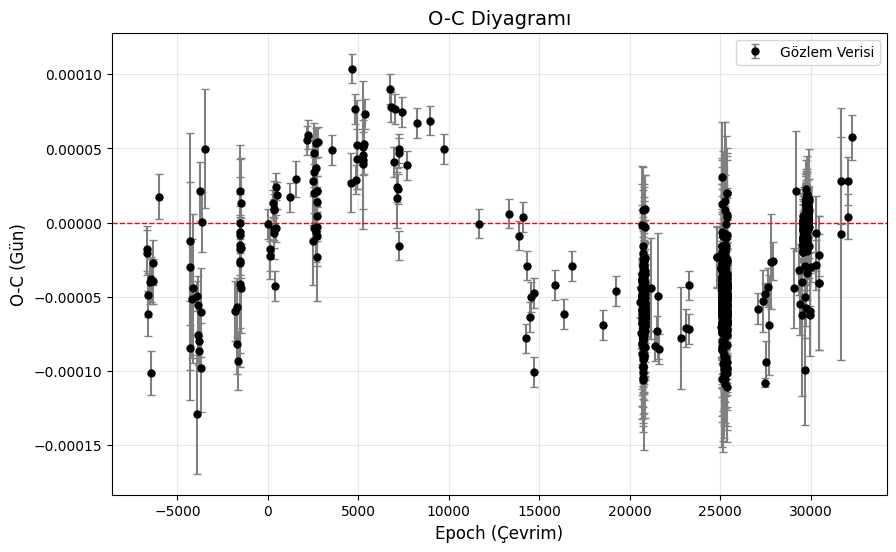

In [3]:
import matplotlib.pyplot as plt

x = oc.data["cycle"]            
y = oc.data["oc"]                
y_err = oc.data["minimum_time_error"] 

plt.figure(figsize=(10, 6)) 

plt.errorbar(
    x, 
    y, 
    yerr=y_err,    
    fmt='o',     
    color='black', 
    ecolor='gray',  
    markersize=5,   
    capsize=3,     
    label='Gözlem Verisi'
)

plt.axhline(0, color='red', linestyle='--', linewidth=1) 
plt.xlabel("Epoch (Çevrim)", fontsize=12)
plt.ylabel("O-C (Gün)", fontsize=12)
plt.title("O-C Diyagramı", fontsize=14)
plt.grid(True, alpha=0.3) 
plt.legend()

# 5. Göster
plt.show()

In [4]:
from ocpy.oc import Linear, Quadratic, Keplerian, KeplerianOld, Parameter

res = oc.fit(
    [kep, lin], 
    tune=2000,       
    draws=2000, 
    chains=4,           
    target_accept=0.95,
    progressbar=True,
    init="adapt_diag" 
)

Initializing NUTS using adapt_diag...
c:\Users\bar1s\miniconda3\envs\ocpy\Lib\site-packages\pytensor\link\c\cmodule.py:2986: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [keplerian_amp, keplerian_e, keplerian_omega, keplerian_P, keplerian_T0, linear_a, linear_b]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 265 seconds.


C:\Users\bar1s\Desktop\oc_py_bar1\oc_py\src\ocpy\oc_pymc.py:301: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


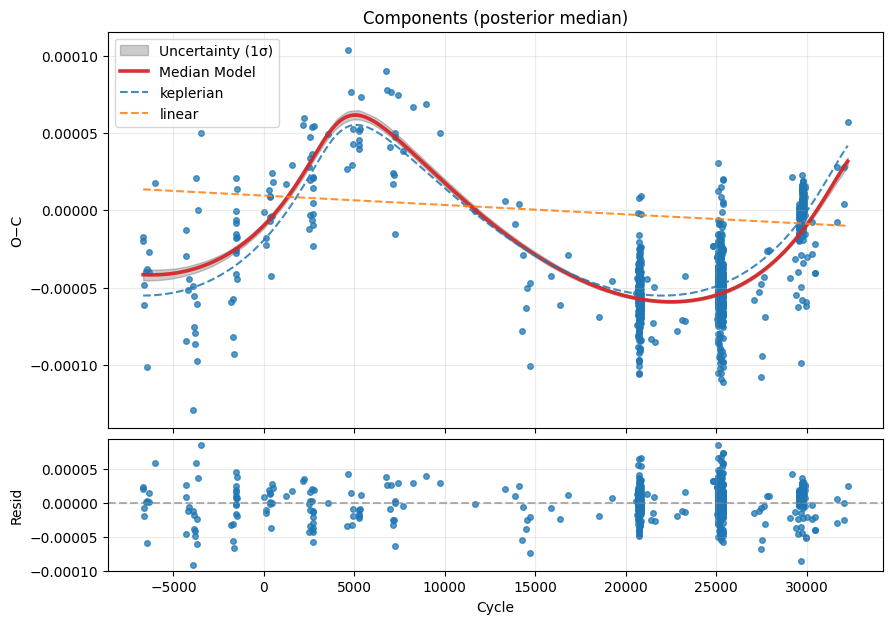

In [5]:
oc.fit_and_report(res)

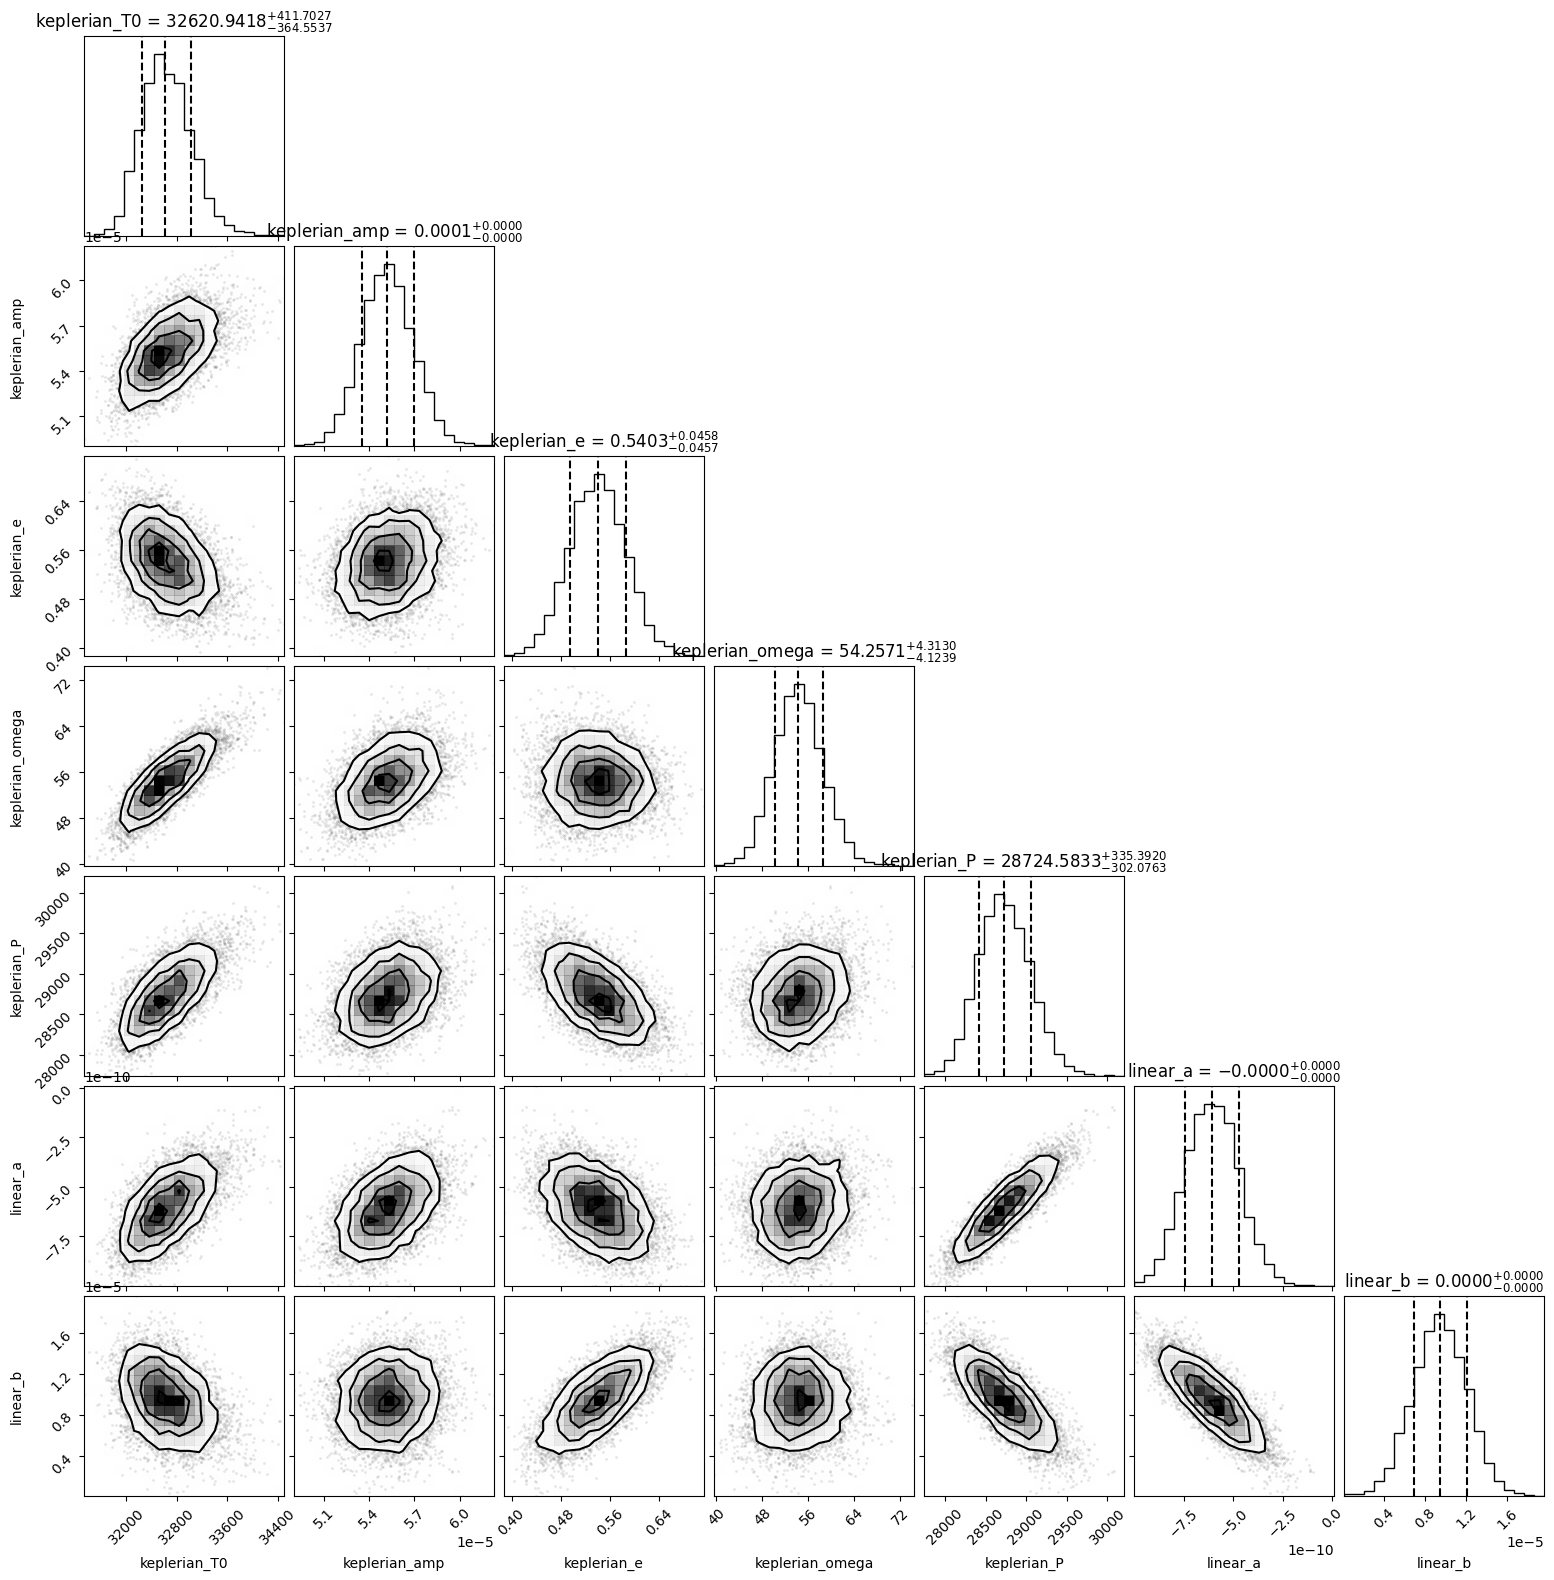

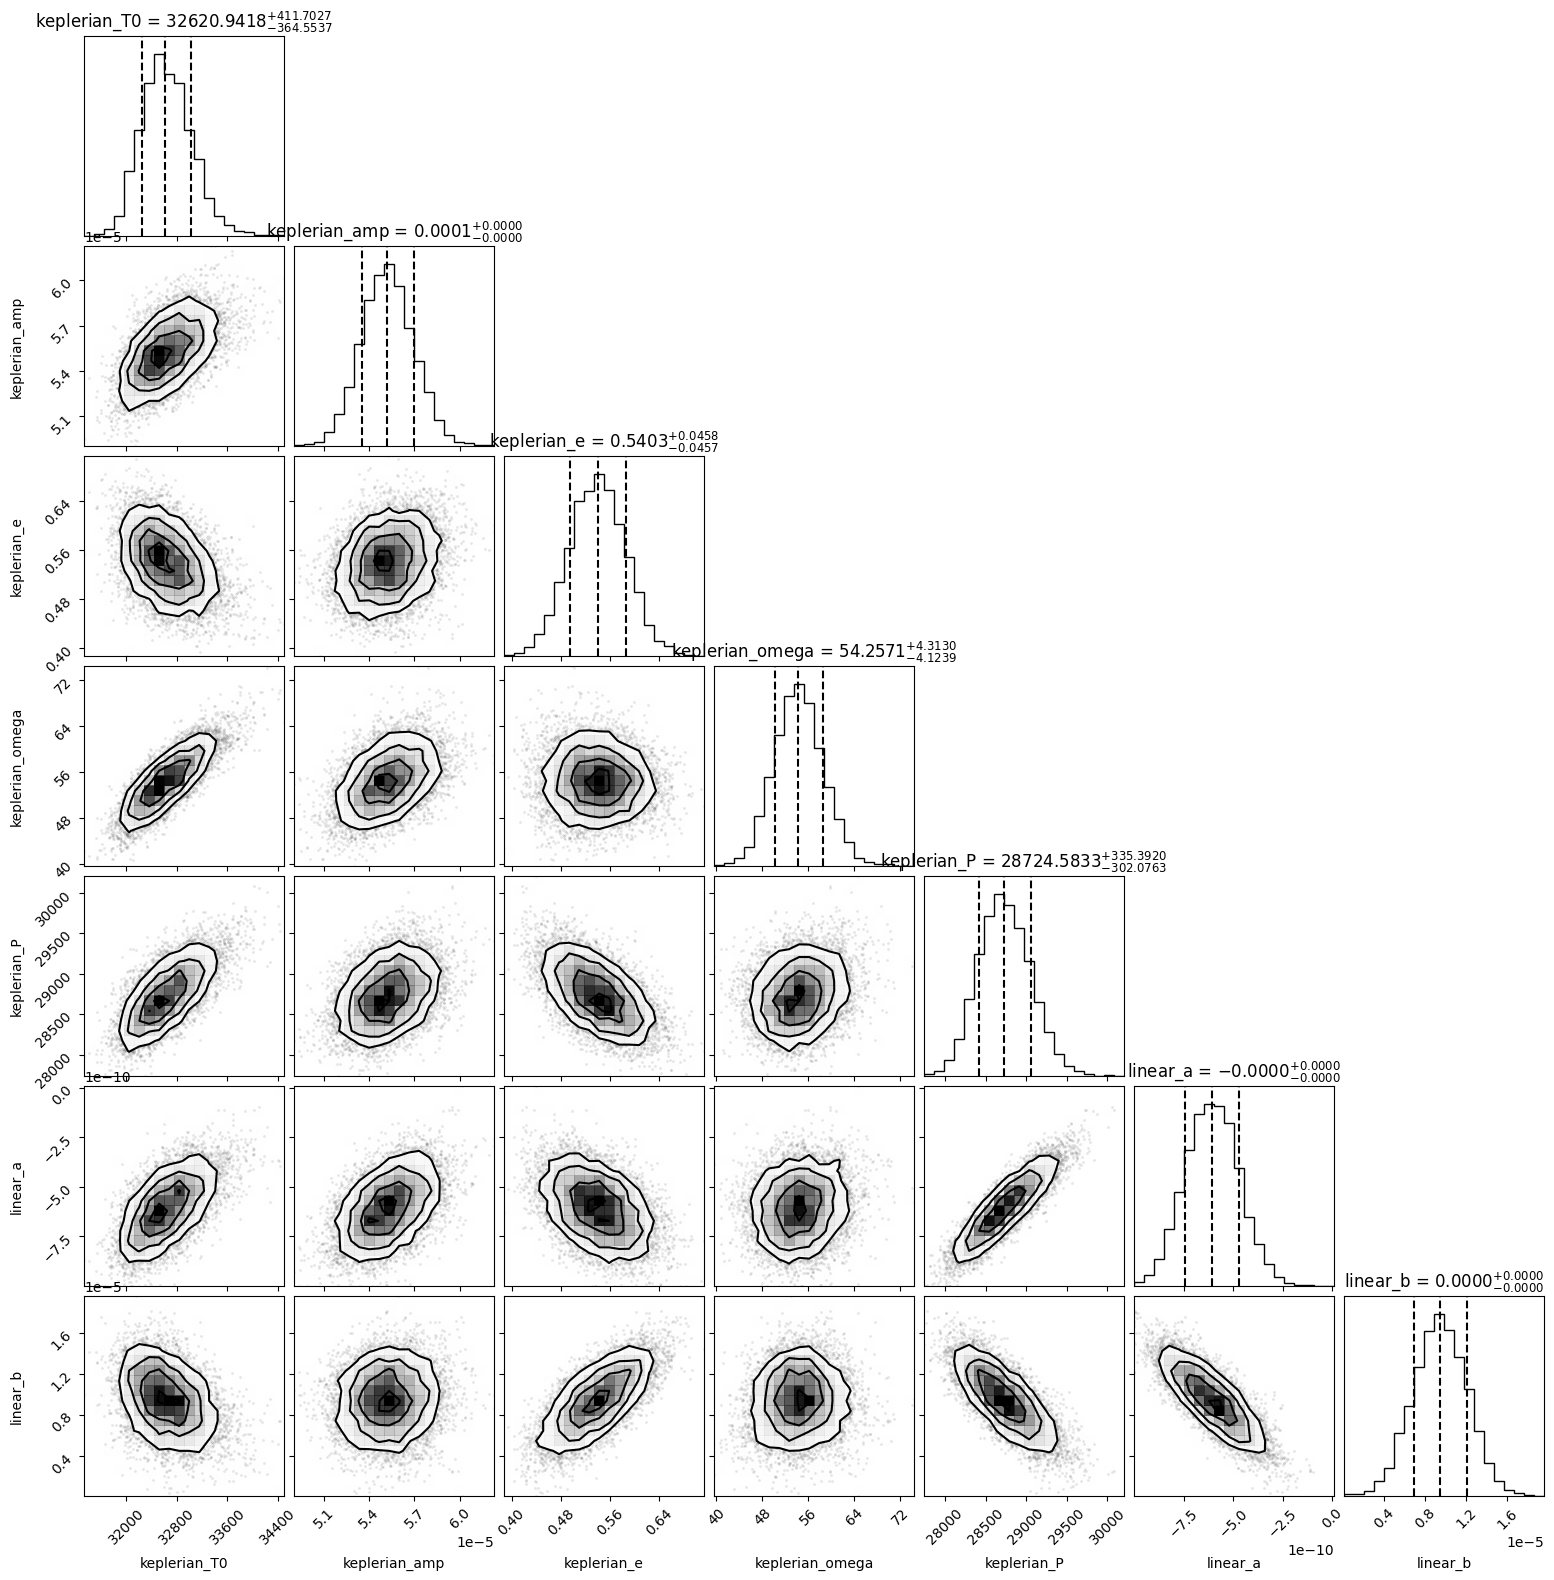

In [6]:
oc.create_corner_plot(res)

In [7]:
res.posterior.median()

<xarray.Dataset> Size: 64B
Dimensions:          ()
Data variables:
    keplerian_T0     float64 8B 3.262e+04
    keplerian_amp    float64 8B 5.52e-05
    keplerian_e      float64 8B 0.5403
    keplerian_omega  float64 8B 54.26
    keplerian_P      float64 8B 2.872e+04
    linear_a         float64 8B -6.062e-10
    linear_b         float64 8B 9.483e-06
    y_model          float64 8B -5.394e-05
Attributes:
    created_at:                 2025-12-08T14:37:37.469673+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.26.1
    sampling_time:              264.7538204193115
    tuning_steps:               2000

In [8]:
import numpy as np

y_model_posterior = res.posterior["y_model"]
y_model_median = y_model_posterior.median(dim=("chain", "draw")).values

y_obs = oc.data["oc"].to_numpy()
y_err = oc.data["minimum_time_error"].to_numpy()

chi2 = np.sum(((y_obs - y_model_median) / y_err) ** 2)

N = len(y_obs)

param_names = [v for v in res.posterior.data_vars if "y_model" not in v and "obs" not in v]
k = len(param_names)

red_chi2 = chi2 / (N - k)

print(f"Toplam Veri Sayısı (N): {N}")
print(f"Serbest Parametre Sayısı (k): {k}")
print("-" * 30)
print(f"Chi-Square (χ²): {chi2:.4f}")
print(f"Reduced Chi-Square (χ²_red): {red_chi2:.4f}")

Toplam Veri Sayısı (N): 910
Serbest Parametre Sayısı (k): 7
------------------------------
Chi-Square (χ²): 2326.3911
Reduced Chi-Square (χ²_red): 2.5763
